<h1 style="text-align: center">
Deep Learning HW3 </br>
VQ-VAE
</h1>


### Full Name: Arman Lotfalikhani
### Student ID: 99109166

## Advantages of VQ-VAE <br>
As the latent space is discrete, we are provided with a more compressed version of the latent space. Also, as the representation is discrete, we avoid the "posterior collapse" (mode collapse) possibility of regular VAEs, which is caused by the network ignoring the latents. At the same time, the performance is similar to a VAE when mode collapse does not happen in it. In addition, VQ-VAE does not have the problem of high variance in regular VAEs.

## Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

## Define the MNIST dataset and data loader

In [46]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Define the VQ-VAE and its quantizer

In [2]:
class VQ_VAE(nn.Module):
    def __init__(self, in_channels, latent_dim, num_embeddings, beta):
        super(VQ_VAE, self).__init__()
        self.hidden_dim=10
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=self.hidden_dim, kernel_size=4,stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(self.hidden_dim, latent_dim, kernel_size=4, stride=2, padding=1)
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=self.hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels= self.hidden_dim, out_channels= in_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.quantizer= Quantizer(latent_dim, num_embeddings, beta)

    def forward(self, x):
        encoded=self.encoder(x)
        quantized, loss_quant=self.quantizer(encoded)
        out=self.decoder(quantized)
        return out, loss_quant, encoded
        
class Quantizer(nn.Module):
    def __init__(self, latent_dim, num_embeddings, beta):
        super(Quantizer, self).__init__()
        self.latent_dim=latent_dim
        self.num_embeddings=num_embeddings
        self.embeddings=nn.Embedding(num_embeddings, latent_dim)
        self.embeddings.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)
        self.beta=beta
    def forward(self, encoded):
        ## encoded has shape B C H W where C is the latent_dim
        embed_rep= self.embeddings.weight.repeat(encoded.shape[0],encoded.shape[2],encoded.shape[3],1,1).permute(0,3,4,1,2)
        encoded_rep=encoded.repeat(self.num_embeddings,1,1,1,1).permute(1,0,2,3,4)
        #Both have shape B N C H W where N=self.num_embeddings and C=self.latent_dim
        _, indices=torch.min(torch.square(embed_rep-encoded_rep), dim=1,keepdim=True)
        quantized=torch.gather(embed_rep, 1, indices).squeeze(dim=1)
        quantized_out= encoded+ (quantized-encoded).detach()
        loss_quantizer= F.mse_loss(encoded.detach(),quantized) + self.beta* F.mse_loss(encoded,quantized.detach())
        return quantized_out, loss_quantizer

## Two helper functions <br>
One performs the training loop and the other takes care of the plot code

In [16]:
def train_vq_vae(model, train_loader, val_loader, num_samples_per_epoch=10, num_epochs=10, learning_rate=1e-3, device='cpu', colored=False):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    model=model.to(device)
    losses=[]
    val_losses=[]
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        val_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            
            data = data.to(device)
            recon, quant_loss, encoded = model(data)
            loss=quant_loss+F.mse_loss(data,recon)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
        if colored==False:
            for index in range(num_samples_per_epoch):
                create_plots_1(data, model, recon, encoded, index, epoch, num_epochs, num_samples_per_epoch)
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(val_loader):

                data = data.to(device)
                recon, quant_loss, encoded = model(data)
                loss=quant_loss+F.mse_loss(data,recon)

                val_loss += loss.item()
        avg_loss = total_loss/train_loader.batch_size
        avg_val_loss = val_loss/val_loader.batch_size
        losses.append(avg_loss)
        val_losses.append(avg_val_loss)
        print(f'VQ-VAE Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}, Validation loss: {avg_val_loss}')
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            #
            best_model ={
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
            }  
    if colored:
        create_plots_2(data, model, recon, encoded, epoch, num_epochs, num_samples_per_epoch)
    torch.save(best_model,'best_vqvae_model.pth')
    print("Best model saved as 'best_vqvae_model.pth'")
    return losses, val_losses

def create_plots_1(data, model, recon, encoded, index, epoch, num_epochs, num_samples_per_epoch):
    in_sample=data[index].permute(1,2,0).cpu().detach().numpy()
    out_sample=recon[index].permute(1,2,0).cpu().detach().numpy()
    encoded_sample=encoded[index].permute(1,2,0).cpu().detach().numpy()
    fig = plt.figure(layout='constrained', figsize=(8, 6))

    fig.suptitle(f'VQ-VAE Epoch [{epoch+1}/{num_epochs}]')

    subfigs = fig.subfigures(1, 2, wspace=0.07,width_ratios=[1, 2])

    subfigs[0].set_facecolor('coral')
    subfigs[1].suptitle('Latent space')

    subaxs = subfigs[0].subplots(3, 1)
    plt.axis('off')
    subaxs[0].imshow(in_sample, cmap='gray')
    subaxs[0].set_title('Original image')
    subaxs[0].axis('off')
    subaxs[2].imshow(out_sample, cmap='gray')
    subaxs[2].set_title('Reconstructed image')
    subaxs[2].axis('off')
    subaxs[1].imshow(encoded_sample.mean(2), cmap='gray')
    subaxs[1].set_title('Quantized image')
    subaxs[1].axis('off')
    embeddings_coordinates=model.quantizer.embeddings.weight.cpu().detach().numpy()
    encoded_coords=torch.flatten(encoded[index],start_dim=1).cpu().detach().numpy()
    subax1=subfigs[1].subplots(1,1)
    subax1.scatter(embeddings_coordinates[:,0],embeddings_coordinates[:,1], marker="^", color='r')
    subax1.scatter(encoded_coords[0],encoded_coords[1])

    num=epoch*num_samples_per_epoch+index+1

    fig.savefig('./figs/Frame '+str(num)+'.png')
    plt.close(fig)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqvae = VQ_VAE(1,2,3,0.2)
losses,val_losses=train_vq_vae(vqvae, train_loader, val_loader, colored=False, device=device)


##################################################
VQ-VAE Epoch [1/10], Loss: 1.4499707111390308, Validation loss: 2.435965479700826

##################################################
VQ-VAE Epoch [2/10], Loss: 0.6046491889283061, Validation loss: 2.458908856380731

##################################################
VQ-VAE Epoch [3/10], Loss: 0.6256554591236636, Validation loss: 2.5195241002365947

##################################################
VQ-VAE Epoch [4/10], Loss: 0.6253722420078702, Validation loss: 2.490697004715912

##################################################
VQ-VAE Epoch [5/10], Loss: 0.6261048490414396, Validation loss: 2.5160397555446252

##################################################
VQ-VAE Epoch [6/10], Loss: 0.6245885443640873, Validation loss: 2.4698099109809846

##################################################
VQ-VAE Epoch [7/10], Loss: 0.6210233103483915, Validation loss: 2.453300340217538

##################################################
VQ-VAE 

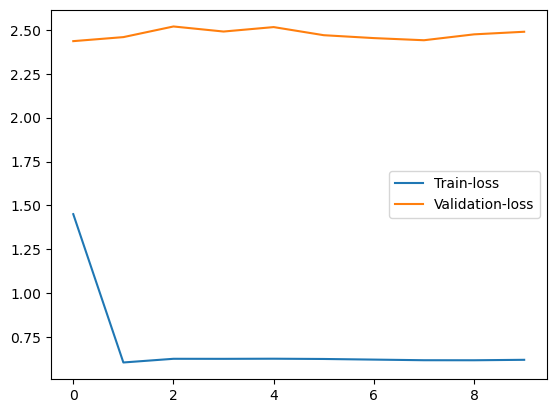

In [50]:
plt.plot(losses,label='Train-loss')
plt.plot(val_losses, label='Validation-loss')
plt.legend()
plt.show()

Using code from https://stackoverflow.com/questions/41228209/making-gif-from-images-using-imageio-in-python for creating a gif

In [51]:
import os
import imageio

png_dir = './figs/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

# Make it pause at the end so that the viewers can ponder
for _ in range(10):
    images.append(imageio.imread(file_path))

imageio.mimsave('./gif/file.gif', images)

C:\Users\Asus\AppData\Local\Temp\ipykernel_12992\3517721734.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
C:\Users\Asus\AppData\Local\Temp\ipykernel_12992\3517721734.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


## Results <br>
This cell can be rerun to see the gif

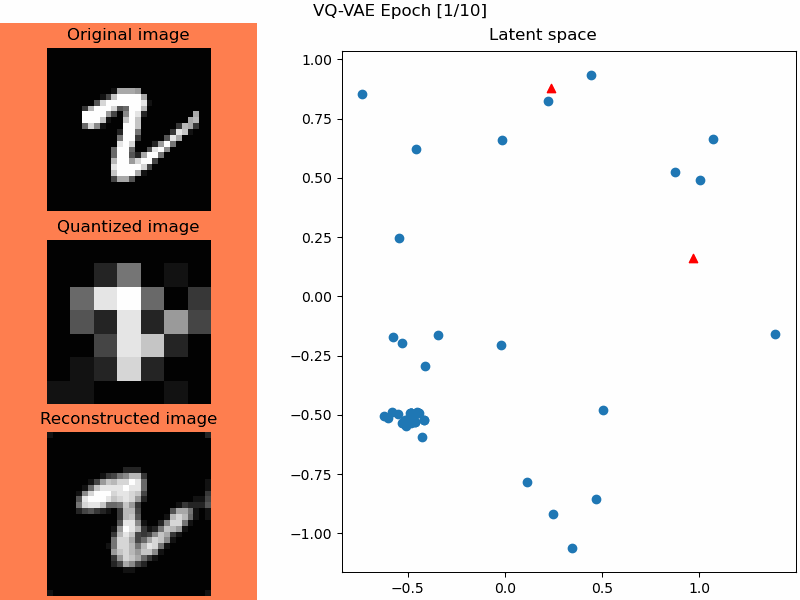

In [52]:
from IPython.display import Image
Image(filename='./gif/file.gif')

## Increasing number of code vectors <br>
For simplicity, this time we only draw plots after the training, and on validation set outputs. This new function is for plots in the colored image scenario, which is used in the original training loop by setting colored= __True__ . A subclass of MNIST has also been deployed, with the condition that the sum across the channels remains the same (If all three of rgb are idependent, some cases happen where the overall pixel values are small)

In [44]:
def create_plots_2(data, model, recon, encoded, epoch, num_epochs, num_samples_per_epoch):
    fig = plt.figure(layout='constrained', figsize=(15, 6))
    fig.suptitle('VQ-VAE')
    subaxs = fig.subplots(3, num_samples_per_epoch)
    for index in range(num_samples_per_epoch):
        in_sample=data[index].permute(1,2,0).cpu().detach().numpy()
        out_sample=recon[index].permute(1,2,0).cpu().detach().numpy()
        encoded_sample=encoded[index].permute(1,2,0).cpu().detach().numpy()

        plt.axis('off')
        subaxs[0,index].imshow(in_sample)
        subaxs[0,index].axis('off')
        subaxs[2,index].imshow(out_sample)
        subaxs[2,index].axis('off')
        subaxs[1,index].imshow(encoded_sample.mean(2), cmap='gray')
        subaxs[1,index].axis('off')
    plt.show()

In [7]:
from PIL import Image

class colored_mnist(datasets.MNIST):
    def __init__(self, train, transform, download):
        super().__init__(root='./data', train=train, transform=transform, download=download)
        return
    def __getitem__(self,idx):
        im, label = super().__getitem__(idx)
        #This random generation ensures that r+b+g=1
        r=random.random()
        g=random.uniform(0,1-r)
        b=1-(r+g)
        return torch.concat((r*im,g*im,b*im),dim=0), label

In [9]:
transform = transforms.Compose([transforms.ToTensor()])
colored_train_dataset = colored_mnist(train=True, transform=transform, download=True)
colored_train_loader = DataLoader(colored_train_dataset, batch_size=64, shuffle=True)
colored_val_dataset = colored_mnist(train=False, transform=transform, download=True)
colored_val_loader = DataLoader(colored_train_dataset, batch_size=32, shuffle=True)

Number of vectors is:  3

##################################################
VQ-VAE Epoch [1/10], Loss: 0.8535094408434816, Validation loss: 0.9753926195262466

##################################################
VQ-VAE Epoch [2/10], Loss: 0.2394390915724216, Validation loss: 0.9162198453850579

##################################################
VQ-VAE Epoch [3/10], Loss: 0.2211861312680412, Validation loss: 0.8453833383973688

##################################################
VQ-VAE Epoch [4/10], Loss: 0.21026525959314313, Validation loss: 0.8394488261255901

##################################################
VQ-VAE Epoch [5/10], Loss: 0.20844122623384465, Validation loss: 0.8450113562284969

##################################################
VQ-VAE Epoch [6/10], Loss: 0.207626564646489, Validation loss: 0.8279042574577034

##################################################
VQ-VAE Epoch [7/10], Loss: 0.20713829444139265, Validation loss: 0.8237964338914026

###########################

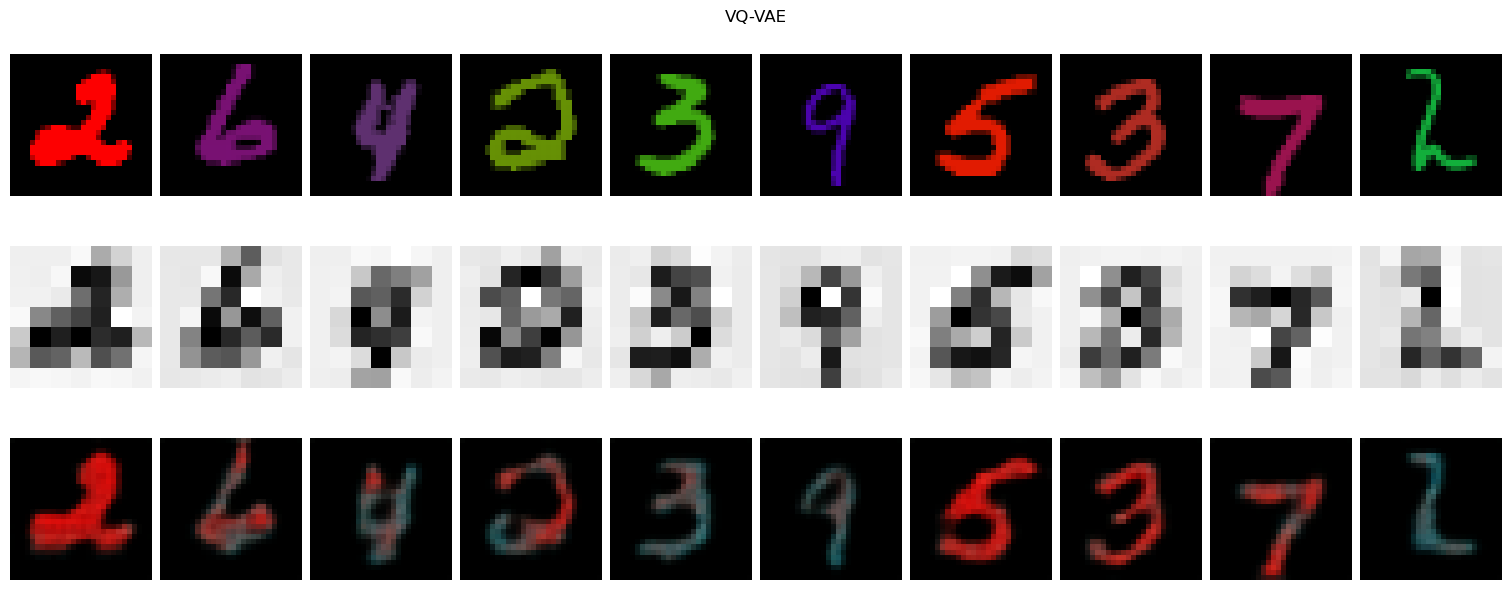

Best model saved as 'best_vqvae_model.pth'
Number of vectors is:  10

##################################################
VQ-VAE Epoch [1/10], Loss: 0.7436953597571119, Validation loss: 0.41015464163501747

##################################################
VQ-VAE Epoch [2/10], Loss: 0.0927909258462023, Validation loss: 0.354202072499902

##################################################
VQ-VAE Epoch [3/10], Loss: 0.08583086263388395, Validation loss: 0.33749921892012935

##################################################
VQ-VAE Epoch [4/10], Loss: 0.08283559777919436, Validation loss: 0.3219393072868115

##################################################
VQ-VAE Epoch [5/10], Loss: 0.08041616930859163, Validation loss: 0.3181462502107024

##################################################
VQ-VAE Epoch [6/10], Loss: 0.079556459619198, Validation loss: 0.31895489143789746

##################################################
VQ-VAE Epoch [7/10], Loss: 0.07925328953569988, Validation loss: 

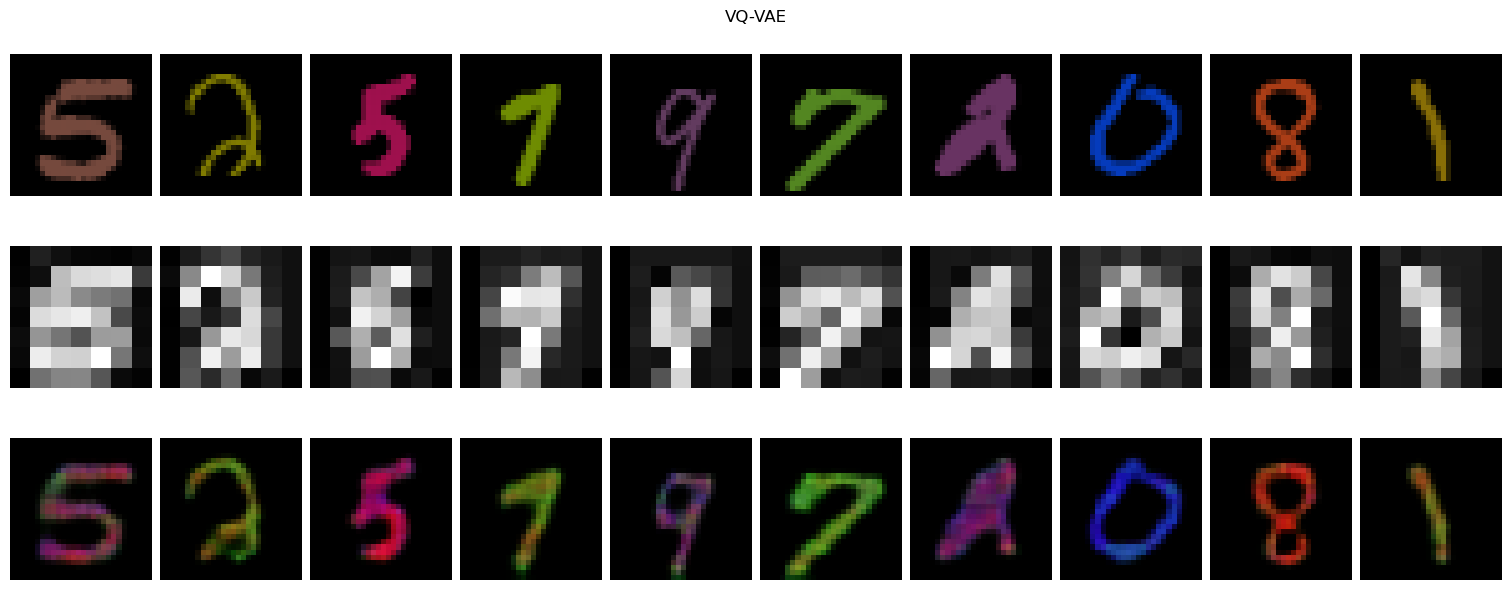

Best model saved as 'best_vqvae_model.pth'
Number of vectors is:  20

##################################################
VQ-VAE Epoch [1/10], Loss: 0.8094429522680002, Validation loss: 0.3514700070518302

##################################################
VQ-VAE Epoch [2/10], Loss: 0.07552015267356182, Validation loss: 0.2808307267696364

##################################################
VQ-VAE Epoch [3/10], Loss: 0.06519599729290348, Validation loss: 0.2451186284670257

##################################################
VQ-VAE Epoch [4/10], Loss: 0.05811239044487593, Validation loss: 0.22470323307061335

##################################################
VQ-VAE Epoch [5/10], Loss: 0.05394746970705455, Validation loss: 0.21330539365590084

##################################################
VQ-VAE Epoch [6/10], Loss: 0.05010322960515623, Validation loss: 0.19210276760713896

##################################################
VQ-VAE Epoch [7/10], Loss: 0.046389132639887976, Validation l

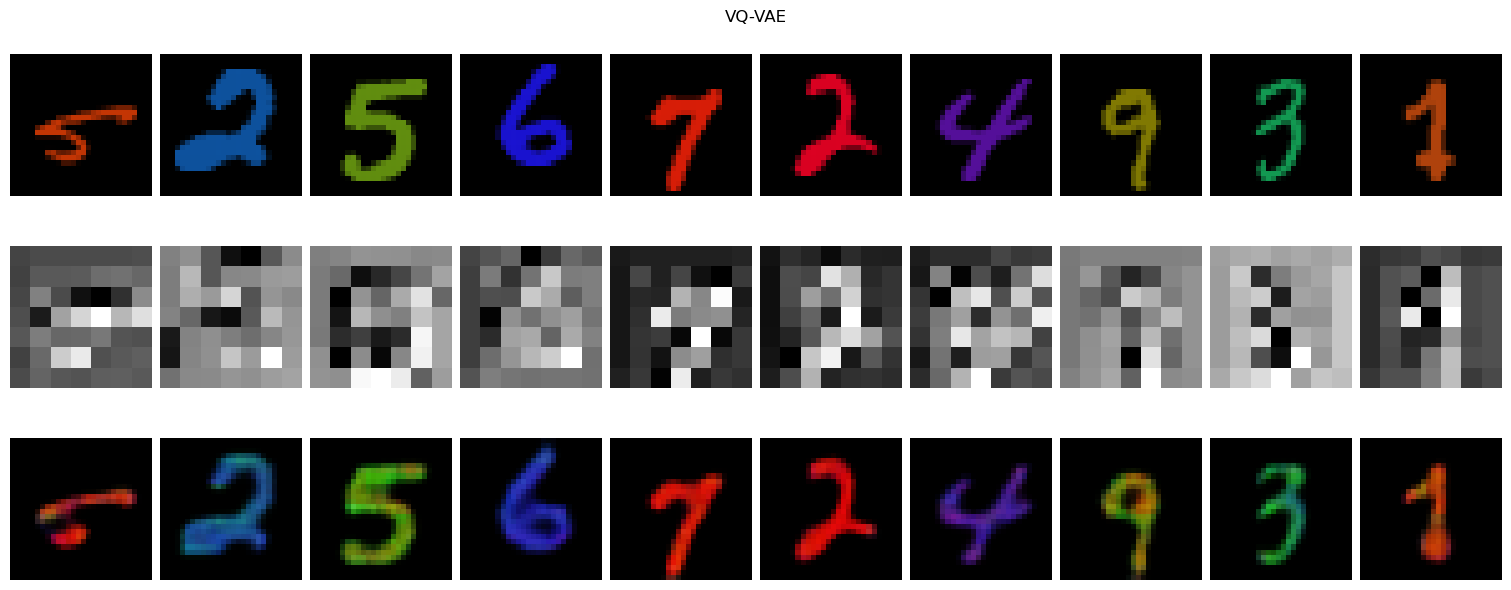

Best model saved as 'best_vqvae_model.pth'
Number of vectors is:  35

##################################################
VQ-VAE Epoch [1/10], Loss: 0.8832492538931547, Validation loss: 0.5140352482558228

##################################################
VQ-VAE Epoch [2/10], Loss: 0.09555930214992259, Validation loss: 0.29278380590403685

##################################################
VQ-VAE Epoch [3/10], Loss: 0.06643216110387584, Validation loss: 0.2478350092205801

##################################################
VQ-VAE Epoch [4/10], Loss: 0.06042791697473149, Validation loss: 0.2374132674667635

##################################################
VQ-VAE Epoch [5/10], Loss: 0.055226459215191426, Validation loss: 0.20761220352142118

##################################################
VQ-VAE Epoch [6/10], Loss: 0.04943043655293877, Validation loss: 0.18758553255611332

##################################################
VQ-VAE Epoch [7/10], Loss: 0.043236470821284456, Validation 

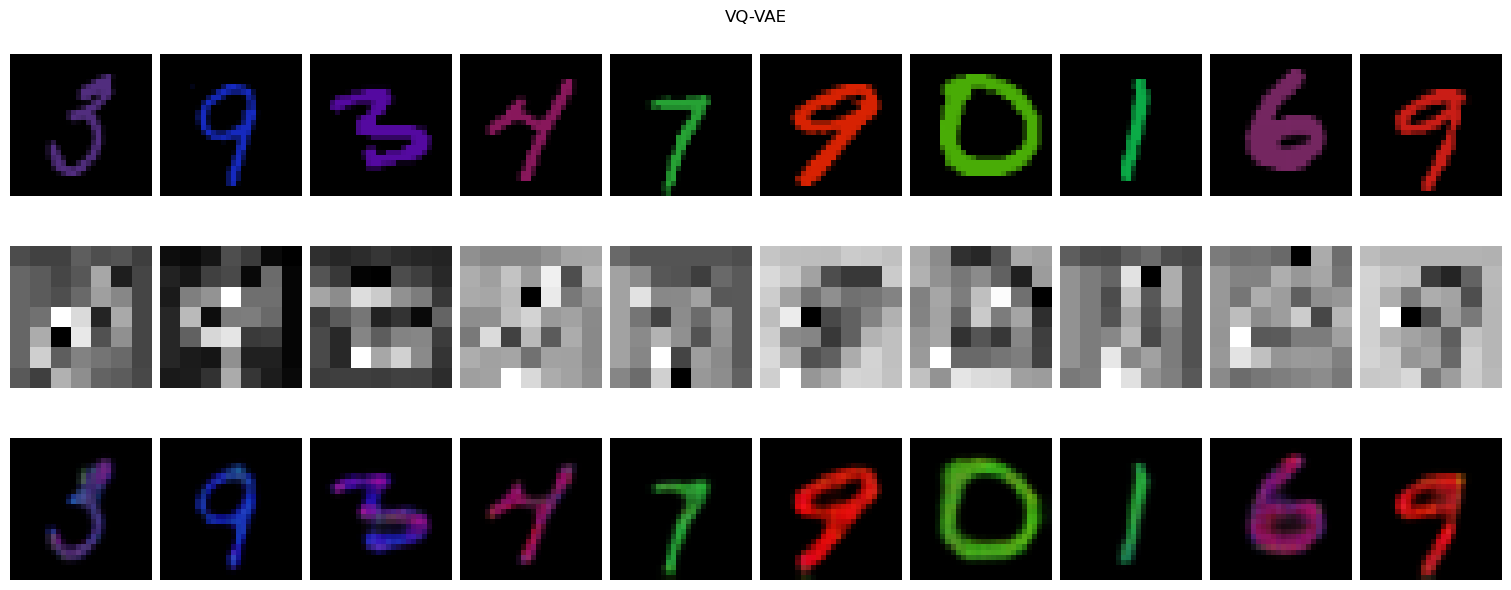

Best model saved as 'best_vqvae_model.pth'
Number of vectors is:  50

##################################################
VQ-VAE Epoch [1/10], Loss: 0.9619415197303169, Validation loss: 0.34854980678937864

##################################################
VQ-VAE Epoch [2/10], Loss: 0.07178668983033276, Validation loss: 0.2557519666443113

##################################################
VQ-VAE Epoch [3/10], Loss: 0.059943682012089994, Validation loss: 0.22824692439462524

##################################################
VQ-VAE Epoch [4/10], Loss: 0.05289635768713197, Validation loss: 0.19452722751157125

##################################################
VQ-VAE Epoch [5/10], Loss: 0.04499685484552174, Validation loss: 0.16920205201313365

##################################################
VQ-VAE Epoch [6/10], Loss: 0.04019104417602648, Validation loss: 0.151671942025132

##################################################
VQ-VAE Epoch [7/10], Loss: 0.03515708582563093, Validation l

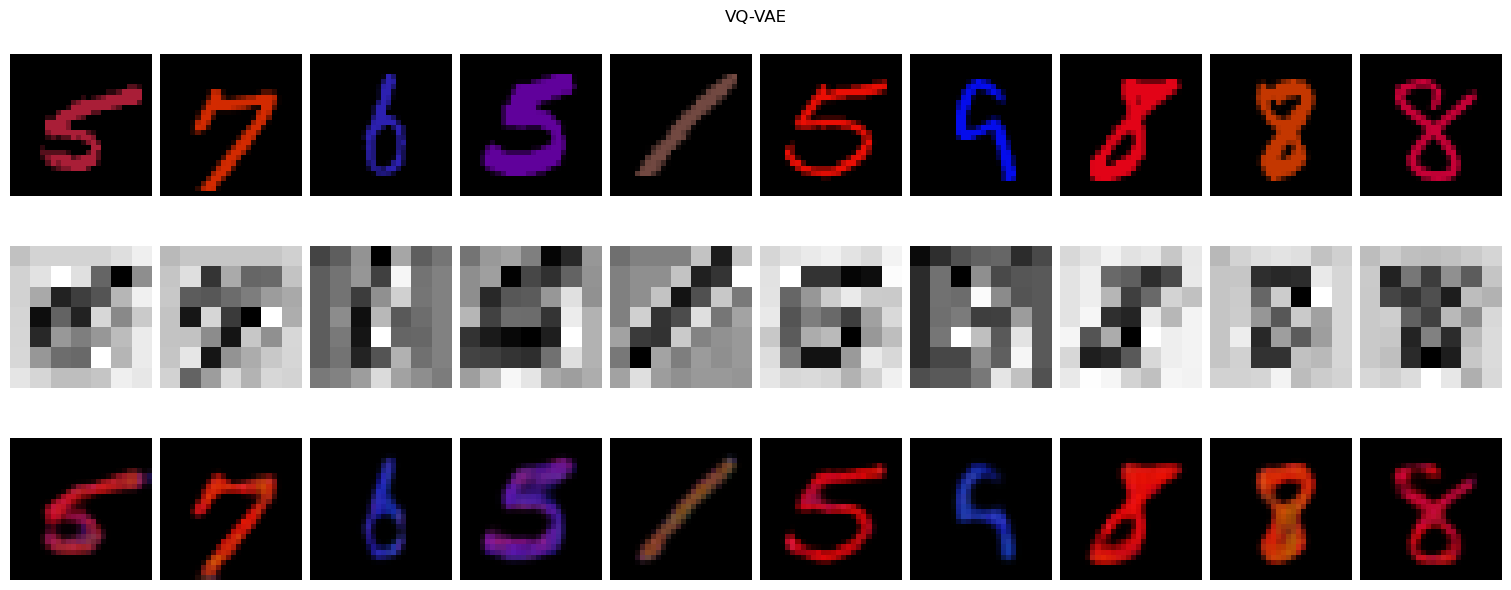

Best model saved as 'best_vqvae_model.pth'


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list=[3, 10, 20, 35, 50]
for item in list:
    vqvae = VQ_VAE(3,2,item,0.2)
    print('Number of vectors is: ', item)
    train_vq_vae(vqvae, colored_train_loader, colored_val_loader, colored=True, device=device)

__Conclusion:__ We should note that the latent represenations are averaged for the plot only, as matplotlib only accepts channel numbers of 1 or 3, and the dimension is 2. We see that increasing the number of codebook vectors does enhance the quality, as the decoded samples' colors match more closely with 50 vector numbers.

Vector dimension is:  3

##################################################
VQ-VAE Epoch [1/10], Loss: 0.5959378336847294, Validation loss: 0.9367440927599091

##################################################
VQ-VAE Epoch [2/10], Loss: 0.22435908141778782, Validation loss: 0.8432777539128438

##################################################
VQ-VAE Epoch [3/10], Loss: 0.19906252188957296, Validation loss: 0.760442325117765

##################################################
VQ-VAE Epoch [4/10], Loss: 0.18497156341618393, Validation loss: 0.722243298223475

##################################################
VQ-VAE Epoch [5/10], Loss: 0.17848626094928477, Validation loss: 0.7162362232629675

##################################################
VQ-VAE Epoch [6/10], Loss: 0.17607666553521995, Validation loss: 0.70277833979344

##################################################
VQ-VAE Epoch [7/10], Loss: 0.17897694659768604, Validation loss: 0.7348362332850229

############################

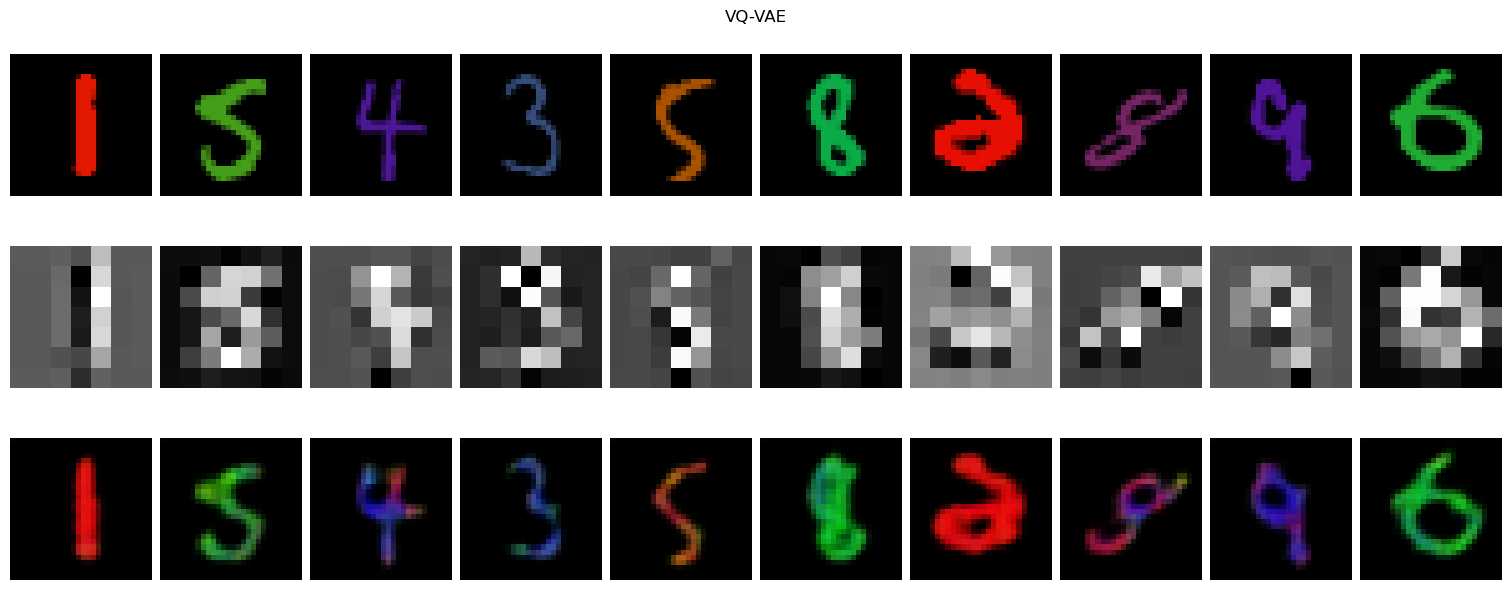

Best model saved as 'best_vqvae_model.pth'
Vector dimension is:  10

##################################################
VQ-VAE Epoch [1/10], Loss: 0.6367012484261068, Validation loss: 0.5977203625661787

##################################################
VQ-VAE Epoch [2/10], Loss: 0.13059874314058106, Validation loss: 0.4753285123879323

##################################################
VQ-VAE Epoch [3/10], Loss: 0.10576636597397737, Validation loss: 0.4015199112909613

##################################################
VQ-VAE Epoch [4/10], Loss: 0.09595864645962138, Validation loss: 0.3708510152355302

##################################################
VQ-VAE Epoch [5/10], Loss: 0.09120337246713461, Validation loss: 0.36053305155655835

##################################################
VQ-VAE Epoch [6/10], Loss: 0.08911049309244845, Validation loss: 0.35775183244550135

##################################################
VQ-VAE Epoch [7/10], Loss: 0.08683278125681682, Validation loss

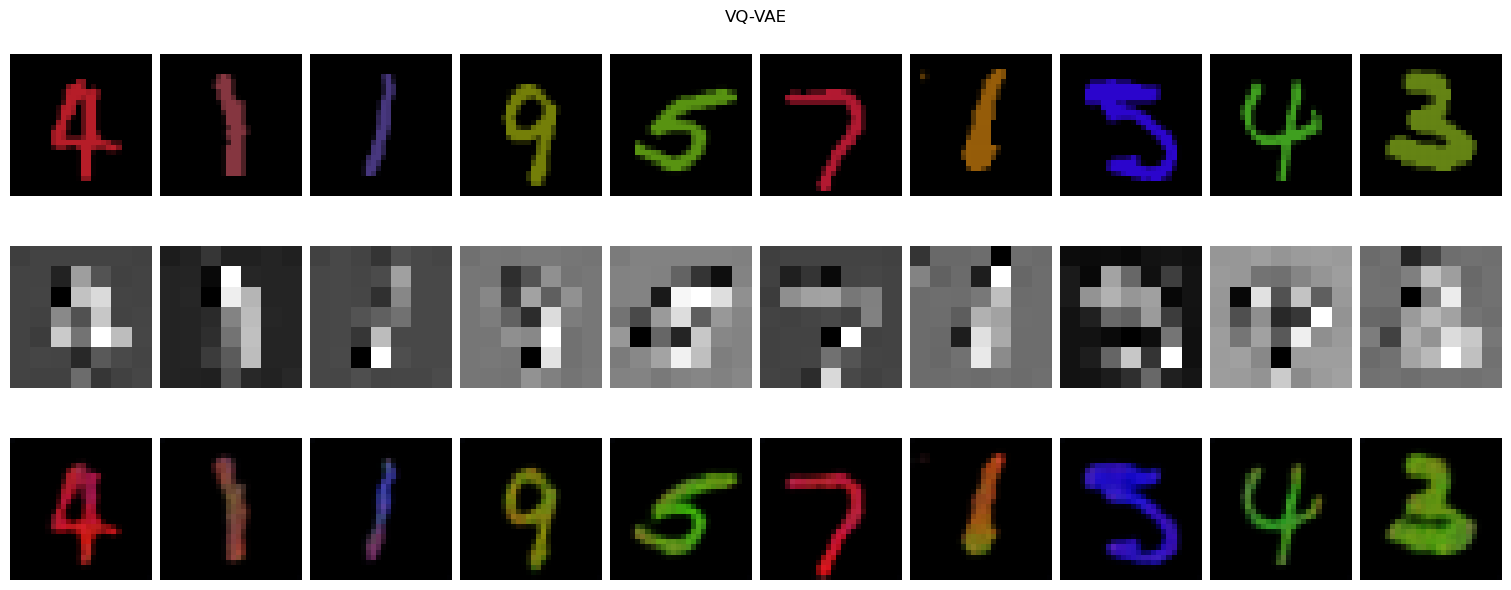

Best model saved as 'best_vqvae_model.pth'
Vector dimension is:  20

##################################################
VQ-VAE Epoch [1/10], Loss: 0.6731028482317924, Validation loss: 0.48731264409434516

##################################################
VQ-VAE Epoch [2/10], Loss: 0.092710326629458, Validation loss: 0.315236350055784

##################################################
VQ-VAE Epoch [3/10], Loss: 0.07221991575352149, Validation loss: 0.26727377705537947

##################################################
VQ-VAE Epoch [4/10], Loss: 0.06330473274647375, Validation loss: 0.24430409928027075

##################################################
VQ-VAE Epoch [5/10], Loss: 0.058252237944543594, Validation loss: 0.22511712362029357

##################################################
VQ-VAE Epoch [6/10], Loss: 0.05477426216384629, Validation loss: 0.21291220233251806

##################################################
VQ-VAE Epoch [7/10], Loss: 0.05210924622224411, Validation los

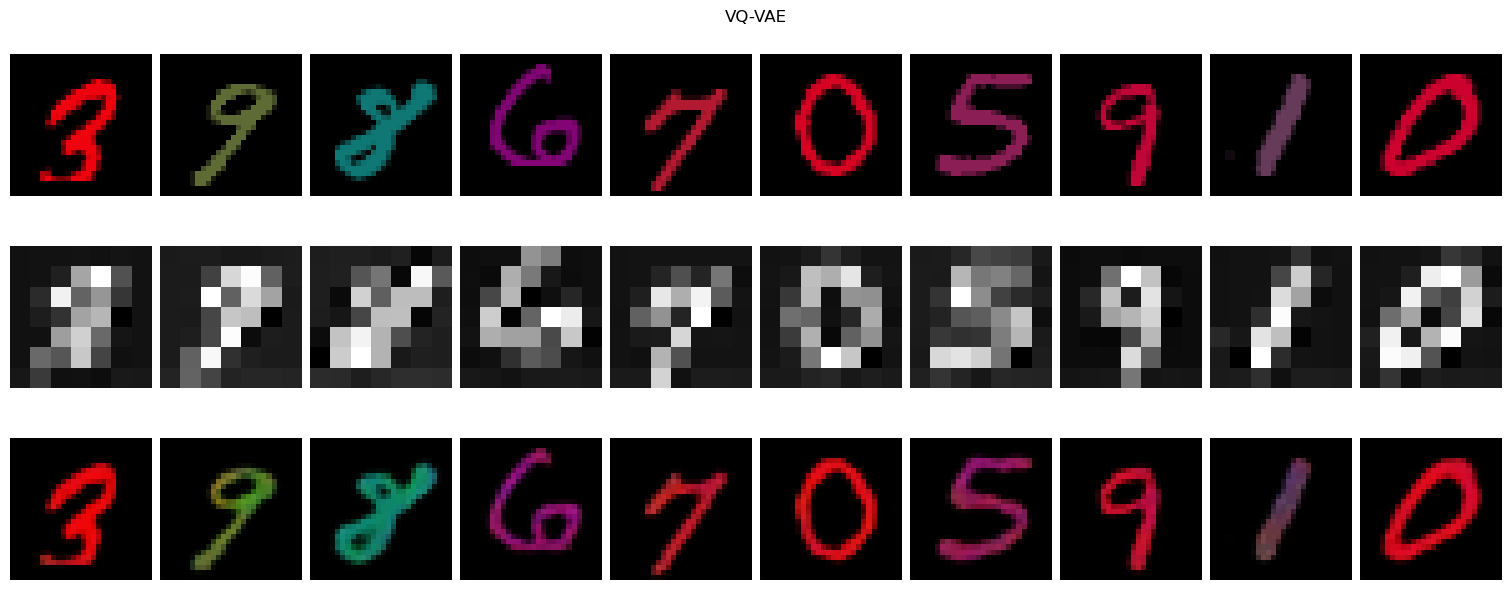

Best model saved as 'best_vqvae_model.pth'
Vector dimension is:  35

##################################################
VQ-VAE Epoch [1/10], Loss: 0.42674738870118745, Validation loss: 0.4114961328887148

##################################################
VQ-VAE Epoch [2/10], Loss: 0.07553493840896408, Validation loss: 0.2521734341062256

##################################################
VQ-VAE Epoch [3/10], Loss: 0.05823336902176379, Validation loss: 0.21946620008384343

##################################################
VQ-VAE Epoch [4/10], Loss: 0.05195795078179799, Validation loss: 0.19742966220655944

##################################################
VQ-VAE Epoch [5/10], Loss: 0.046979902013845276, Validation loss: 0.1784258005936863

##################################################
VQ-VAE Epoch [6/10], Loss: 0.04371006911605946, Validation loss: 0.17009073875669856

##################################################
VQ-VAE Epoch [7/10], Loss: 0.0413266622563242, Validation lo

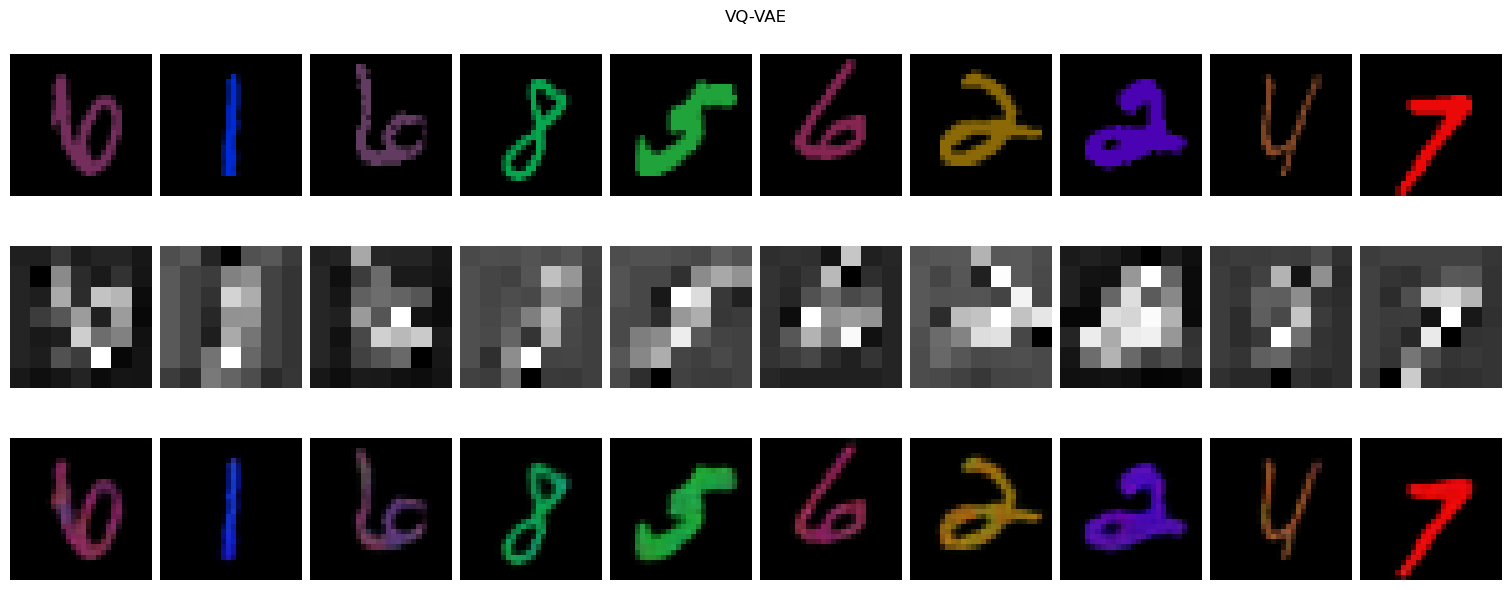

Best model saved as 'best_vqvae_model.pth'
Vector dimension is:  50

##################################################
VQ-VAE Epoch [1/10], Loss: 0.3747531997432816, Validation loss: 0.26924193307058886

##################################################
VQ-VAE Epoch [2/10], Loss: 0.05736181956672226, Validation loss: 0.20292519576469203

##################################################
VQ-VAE Epoch [3/10], Loss: 0.046205793747503776, Validation loss: 0.16966616743593477

##################################################
VQ-VAE Epoch [4/10], Loss: 0.03980617224078742, Validation loss: 0.1494268002352328

##################################################
VQ-VAE Epoch [5/10], Loss: 0.03590200256803655, Validation loss: 0.1364873966194864

##################################################
VQ-VAE Epoch [6/10], Loss: 0.0335429746992304, Validation loss: 0.13271238249944872

##################################################
VQ-VAE Epoch [7/10], Loss: 0.032376334584114375, Validation l

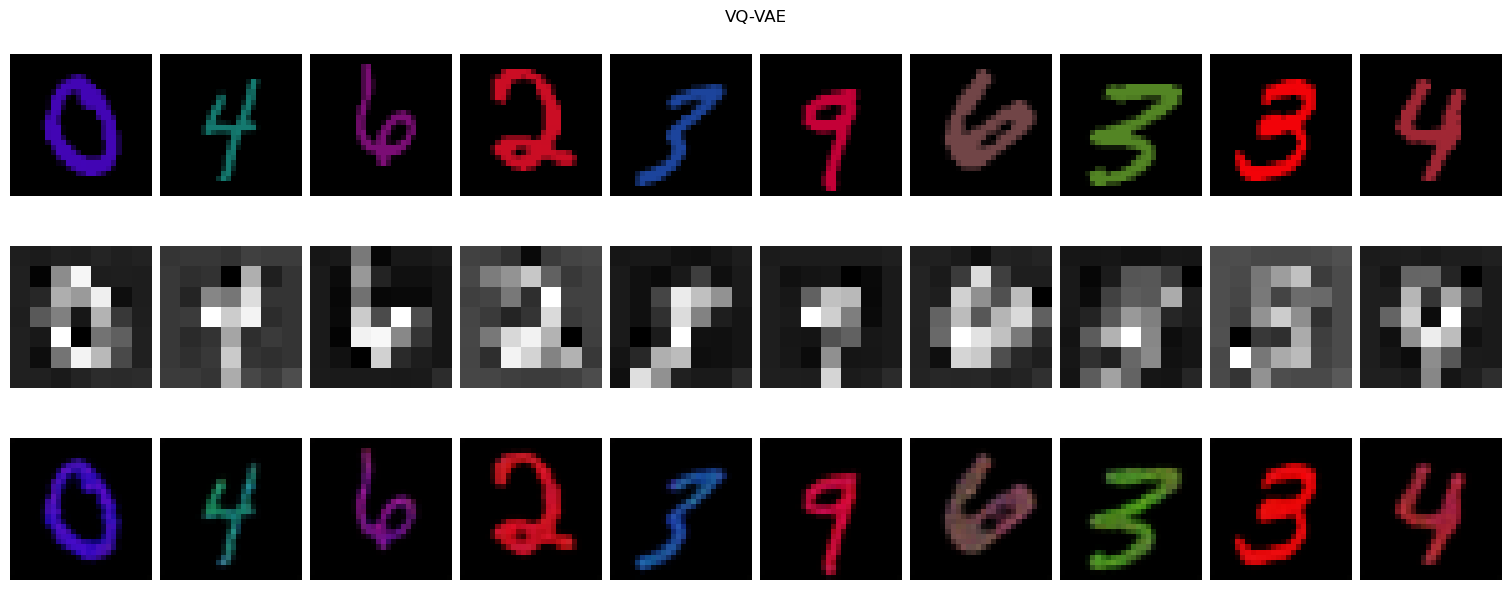

Best model saved as 'best_vqvae_model.pth'


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
list=[3, 10, 20, 35, 50]
for item in list:
    vqvae = VQ_VAE(3,item,3,0.2)
    print('Vector dimension is: ', item)
    train_vq_vae(vqvae, colored_train_loader, colored_val_loader, colored=True, device=device)

__Conclusion:__ We do not see a major difference in the color reconstruction, and an increase from 3 to 10 may be enough. In all cases, there is still some color error in the reconstructed images. It shows that the VQ-VAE already performs well with a low complexity.